Data Loaded Successfully!
Initial DataFrame columns: ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
Columns after filtering for first month: ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SE

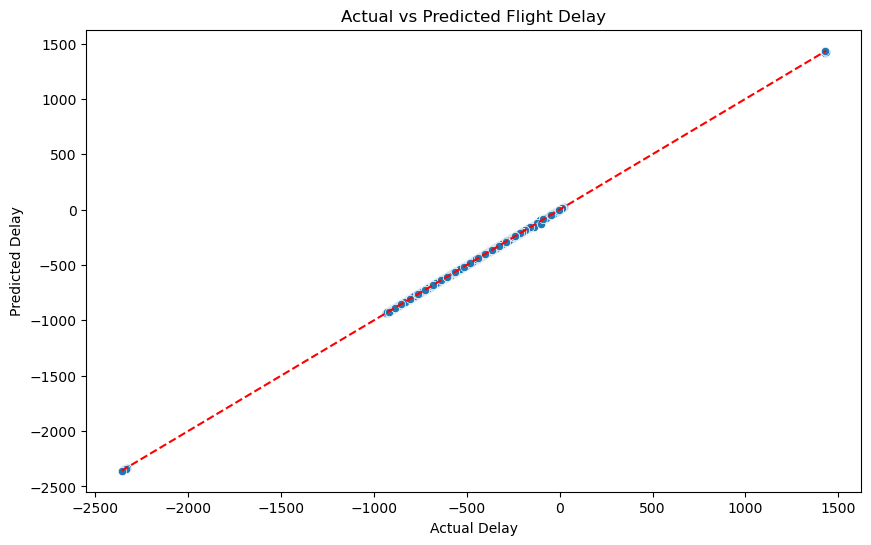

In [4]:
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

class FlightDelayPipeline:
    def __init__(self, file_path):
        """Initialize pipeline with CSV file path"""
        self.file_path = file_path
        self.df = None
        self.numerical_cols = []
        self.categorical_cols = []
        self.time_cols = []
        self.scaler = StandardScaler()
        self.model = None
        self.original_means = {}
        self.original_stds = {}

    def load_data(self):
        """Load CSV using polars"""
        self.df = pl.read_csv(self.file_path)
        print("Data Loaded Successfully!")
        print(f"Initial DataFrame columns: {self.df.columns}")

    def filter_first_month(self):
        """Filter data for the first month only"""
        self.df = self.df.filter(pl.col("MONTH") == 1)
        print(f"Columns after filtering for first month: {self.df.columns}")

    def drop_unnecessary_columns(self):
        """Drop irrelevant columns like year, tail-number"""
        self.df = self.df.drop(["YEAR", "TAIL_NUMBER", "CANCELLATION_REASON"])
        print(f"Columns after dropping unnecessary columns: {self.df.columns}")

    def identify_columns(self):
        """Identify numerical, categorical, and time-related columns"""
        self.numerical_cols = [col for col in self.df.columns if self.df[col].dtype in [pl.Int64, pl.Float64]]
        self.categorical_cols = [col for col in self.df.columns if self.df[col].dtype == pl.Utf8]
        self.time_cols = [col for col in self.df.columns if "time" in col.lower()]

        print(f"Numerical Columns: {self.numerical_cols}")
        print(f"Categorical Columns: {self.categorical_cols}")
        print(f"Time Columns: {self.time_cols}")

    def convert_time_columns(self):
        """Convert HHMM formatted time columns to minutes"""
        print(f"Current DataFrame columns before conversion: {self.df.columns}")
        
        for col in self.time_cols:
            if col in self.df.columns:  # Check if the column exists
                if self.df[col].max() > 1000:  # Assuming HHMM format has values > 1000
                    # Convert the time from HHMM to total minutes
                    self.df = self.df.with_columns(
                        ((pl.col(col) // 100) * 60 + (pl.col(col) % 100)).alias(f"{col}_minutes")
                    )
                    print(f"Converted {col} to minutes")
                    
                # Drop the original time columns after conversion
                self.df = self.df.drop(col)
            else:
                print(f"Warning: Column {col} does not exist in the DataFrame.")

        print(f"Columns after converting time: {self.df.columns}")  # Print columns after conversion

    def update_numerical_columns(self):
        """Update numerical columns after time conversion"""
        # After converting time columns, update the numerical columns
        self.numerical_cols = [col for col in self.df.columns if self.df[col].dtype in [pl.Int64, pl.Float64]]
        print(f"Updated Numerical Columns: {self.numerical_cols}")

    def encode_categorical_columns(self):
        """Encode categorical columns using one-hot or label encoding"""
        for col in self.categorical_cols:
            if col in self.df.columns:
                if self.df[col].n_unique() < 10:
                    # One-hot encode for small categories
                    self.df = self.df.with_columns(pl.get_dummies(self.df[col]))
                else:
                    # Label encode for larger categories
                    le = LabelEncoder()
                    self.df = self.df.with_columns(pl.Series(col, le.fit_transform(self.df[col].to_list())).alias(col))
                print(f"Encoded categorical column: {col}")
            else:
                print(f"Warning: Column {col} does not exist for encoding.")

    def add_feature_engineering(self):
        """Feature Engineering - Create new relevant features"""
        features = []
    
        if "DEPARTURE_TIME_minutes" in self.df.columns and "SCHEDULED_DEPARTURE" in self.df.columns:
            features.append((pl.col("DEPARTURE_TIME_minutes") - pl.col("SCHEDULED_DEPARTURE")).alias("departure_delay"))
    
        if "ARRIVAL_TIME_minutes" in self.df.columns and "SCHEDULED_ARRIVAL" in self.df.columns:
            features.append((pl.col("ARRIVAL_TIME_minutes") - pl.col("SCHEDULED_ARRIVAL")).alias("arrival_delay"))
    
        if "DEPARTURE_DELAY" in self.df.columns and "ARRIVAL_DELAY" in self.df.columns:
            features.append((pl.col("DEPARTURE_DELAY") + pl.col("ARRIVAL_DELAY")).alias("total_delay"))
    
        if "ELAPSED_TIME" in self.df.columns and "TAXI_OUT" in self.df.columns:
            features.append((pl.col("ELAPSED_TIME") + pl.col("TAXI_OUT")).alias("total_time"))
    
        if "DISTANCE" in self.df.columns:
            features.append(pl.col("DISTANCE").log().alias("log_distance"))
    
        # Add the new columns if any were defined
        if features:
            self.df = self.df.with_columns(features)
            print(f"Added new features: {[f.name for f in features]}")
        else:
            print("No features were added because required columns were missing.")

        print(f"Columns after feature engineering: {self.df.columns}")  # Print columns after feature engineering

    def handle_missing_values(self):
        """Replace missing values with mean (numerical) or mode (categorical)"""
        for col in self.df.columns:
            if col in self.numerical_cols:
                self.df = self.df.with_columns(pl.col(col).fill_null(pl.col(col).mean()))
                print(f"Filled missing values in numerical column: {col}")
            elif col in self.categorical_cols:
                mode_value = self.df[col].mode().first()
                self.df = self.df.with_columns(pl.col(col).fill_null(mode_value))
                print(f"Filled missing values in categorical column: {col} with mode: {mode_value}")

    def remove_outliers(self):
        """Remove outliers using IQR"""
        for col in self.numerical_cols:
            if col in self.df.columns:  # Check if the column exists
                q1 = self.df[col].quantile(0.25)
                q3 = self.df[col].quantile(0.75)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                self.df = self.df.filter((pl.col(col) >= lower_bound) & (pl.col(col) <= upper_bound))
                print(f"Removed outliers from column: {col}")
            else:
                print(f"Warning: Column {col} does not exist for outlier removal.")

    def scale_features(self):
        """Scale numerical features using StandardScaler"""
        # Fit scaler on numerical columns and store means and stds for descaling
        X = self.df.select(self.numerical_cols).to_numpy()
        self.scaler.fit(X)
        self.original_means = {col: self.scaler.mean_[i] for i, col in enumerate(self.numerical_cols)}
        self.original_stds = {col: self.scaler.scale_[i] for i, col in enumerate(self.numerical_cols)}

        scaled_data = self.scaler.transform(X)
        for i, col in enumerate(self.numerical_cols):
            self.df = self.df.with_columns(pl.Series(name=col, values=scaled_data[:, i]))
            print(f"Scaled numerical column: {col}")

    def save_cleaned_data(self, file_name):
        """Save cleaned dataset"""
        self.df.write_csv(file_name)
        print("Cleaned Data Saved!")

    def train_model(self):
        """Train a regression model and evaluate"""
        X = self.df.drop("departure_delay").to_numpy()
        y = self.df["departure_delay"].to_numpy()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.model.fit(X_train, y_train)
        
        # Predicting
        y_pred = self.model.predict(X_test)

        # Evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        print(f"Model trained successfully!")
        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Error: {mae}")

        # Visualization
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_test, y=y_pred)
        plt.xlabel("Actual Delay")
        plt.ylabel("Predicted Delay")
        plt.title("Actual vs Predicted Flight Delay")
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line
        plt.show()

    def run_pipeline(self):
        """Run the entire data processing and modeling pipeline"""
        self.load_data()
        self.filter_first_month()
        self.drop_unnecessary_columns()
        self.identify_columns()
        self.convert_time_columns()
        self.update_numerical_columns()  # Update numerical columns after conversion
        self.encode_categorical_columns()
        self.add_feature_engineering()
        self.handle_missing_values()
        self.remove_outliers()
        self.scale_features()
        self.save_cleaned_data('cleaned_flight_data.csv')
        self.train_model()

# Example usage:
file_path = 'flights.csv'  # Specify the correct path to your dataset
pipeline = FlightDelayPipeline(file_path)
pipeline.run_pipeline()
